# Homework - Linear Regression

# Packages needed

In [127]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2
from scipy.linalg import qr
from scipy import stats

# Exercice 1


In the first exercice, we will try to apply a linear regression to a target function when d<n, n>d and d=n and with different methods : SDV, QR with vackward substitution and simple inversion.

First experiment with d<n - Backward Substitution with QR decomposition

In [128]:
# Parameters d<n
n = 150
d = 50
# the scale is the error of our targeted function
scale = 0.05

In [129]:
# targeted function
def function_f(x, c=16):
  return x*np.sin(c*x)

In [130]:
# creation of y and x
x = np.sort(np.random.uniform(size=n))
eps = np.random.normal(scale=scale,size=n)

Y = function_f(x)+eps

In [131]:
# function used for regression

# polynomial
def function_poly(x,i,d):
  return np.power(x,i)

# exponential
def function_exp(x,i,d):
  sigma_i = 2
  nu_i = (i-1)/(d-1)
  return np.exp(-(x-nu_i)*(x-nu_i)/sigma_i*sigma_i)

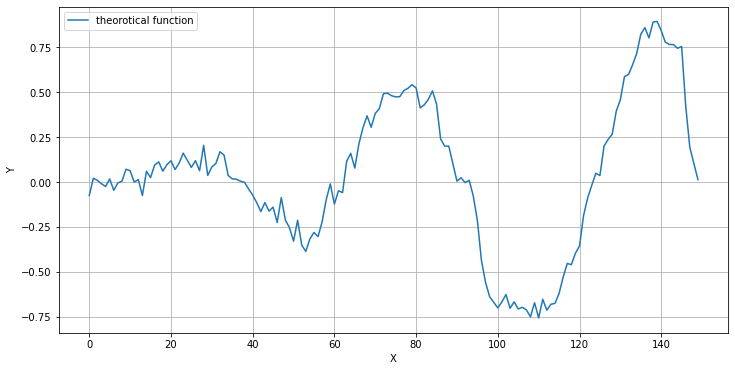

In [132]:
plt.figure(figsize=(12, 6))

plt.xlabel("X")
plt.ylabel("Y")

plt.grid()

plt.plot(Y)
plt.legend(["theorotical function"])

Creation of X with polynomial functions here

In [133]:
def create_X(x,function_gen,d):
  X = np.zeros((n,d))
  for i in range(d):
    X[:,i]=function_gen(x,i,d)

  return X

In [134]:
X = create_X(x,function_poly,d)

Functions used for linear regression

With SVD, we try to find the pseudo-inverse of the matrix :

In [135]:
def create_D_inv(D, U, VT):
  # the inverse of a diagonal matrix
  D_inv = 1/D
  D_inv = np.diag(D_inv) # matrice

  nb_to_add = np.abs(U.shape[0]-VT.shape[0])

  # this if condition is used to know where to add 0
  if U.shape[0]<VT.shape[0]:
    add_on = np.zeros((nb_to_add,len(D_inv)))
    D_inv = np.vstack((D_inv,add_on))
  else :
    add_on = np.zeros((len(D_inv),nb_to_add))
    D_inv = np.hstack((D_inv,add_on))

  # we return the inverse of D in the good format
  return D_inv

In [136]:
def pseudo_inverse(A):
  # use of SVD to find the pseudo inverse
  U, D, VT = np.linalg.svd(A)

  # find the inverse of a diagonal matrix and put it in the good format
  D_inv = create_D_inv(D,U,VT)
  V = VT.transpose()
  UT = U.transpose()

  # find the pseudo inverse
  A_pinv = np.matmul(np.matmul(V,D_inv),UT)
  return A_pinv

With QR, we use backward substitution to find the inverse of a triangular matrix (R) :

In [137]:
def backward_substitution(A, b):
    n = b.size
    x = np.zeros_like(b)

    if A[n-1, n-1] == 0:
        raise ValueError


    x[n-1] = b[n-1]/A[n-1, n-1]
    C = np.zeros((n,n))
    for i in range(n-2, -1, -1):
        bb = 0
        for j in range (i+1, n):
            bb += A[i, j]*x[j]

        C[i, i] = b[i] - bb
        x[i] = C[i, i]/A[i, i]

    return x

Main function for linear regression

In [138]:
def linear_regression(Y, X, SVD_bool = False, basic_inv_bool = False, qr_bool = False):
  
  # d > n
  if (X.shape[0]<X.shape[1] or SVD_bool) and (not basic_inv_bool and not qr_bool) :
    print("SVD used (with also QR decomposition)")

    Q, R = qr(X)
    R_inv = pseudo_inverse(R) # we find the pseudo inverse
    beta = np.matmul(R_inv,np.matmul(Q.transpose(),Y))

  # d < n
  elif (X.shape[0]>X.shape[1] or qr_bool) and (not basic_inv_bool and not SVD_bool) :
    print("SVD not used, QR decomposition > backward Substitution")

    # we QR decompose and find the beta with backward substitution 
    Q, R = qr(X, mode = 'economic')
    B = np.matmul(Q.transpose(),Y)
    beta = backward_substitution(R,B)

  # d = n
  elif (X.shape[0]==X.shape[1] or basic_inv_bool) and (not qr_bool and not SVD_bool):
    # ridge to avoid bad condition
    lambda_ = 0.0000001
    print("Basic inversion used, with lambda : ", lambda_)

    # we decompose the basic formula (XtX+lambda)^-1 XtY in these lines
    # we also obttain XX_1 and z_n that will be useful for the recursivity
    XX = np.matmul(X.transpose(),X)
    XX_1 = np.linalg.inv(XX + lambda_*np.identity(len(XX)))

    z_n = np.matmul(X.transpose(),Y)
    beta = np.matmul(XX_1,z_n)

    basic_inv_bool = True
  else :
    raise(Exception('Shape of X not in good format'))
  
  if basic_inv_bool :
    return beta, XX_1, z_n
  else :
    return beta, None, None


In [139]:
beta, XX_1, z_n = linear_regression(Y,X)  # d < n
print("Shape of beta :\n", beta.shape)
print("First five rows of beta :\n", beta[:5])

SVD not used, QR decomposition > backward Substitution
Shape of beta :
 (50,)
First five rows of beta :
 [-1.08624743e-01 -5.57080293e+01  8.75427275e+03 -5.51706820e+05
  1.92320538e+07]


We sometime find the backward substitution gives sometimes some irregularity on the regression curve compared to other methods.

Text(0.5, 1.0, 'QR decomposition with backward substitution (d<n)')

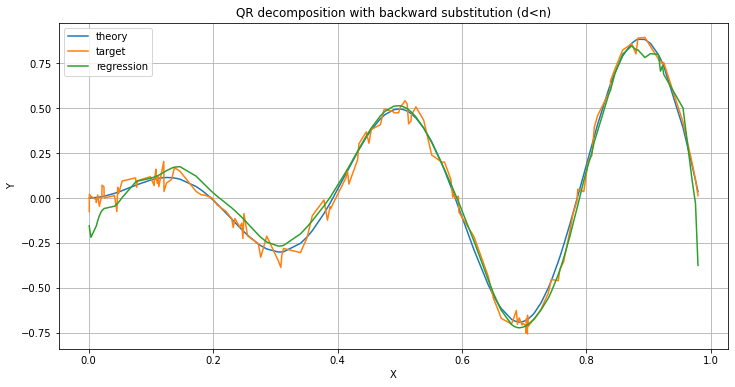

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(x,function_f(x))
plt.plot(x,Y)
plt.plot(x,np.matmul(X,beta))

plt.xlabel("X")
plt.ylabel("Y")

plt.grid()

plt.legend(["theory", "target", "regression"])
plt.title("QR decomposition with backward substitution (d<n)")

This is the same experiment but ordering to solve this using a basic inversion with a $\lambda$ (ridge).

In [141]:
beta, XX_1, z_n = linear_regression(Y,X,basic_inv_bool=True)  # d < n
print(beta)

Basic inversion used, with lambda :  1e-07
[-8.90297474e-02  5.07528763e+00 -2.24577426e+01 -1.05593935e+02
  5.39443966e+02 -3.26046736e+02 -5.21437866e+02 -1.14555432e+02
  2.96323431e+02  4.37181783e+02  3.33258112e+02  1.16395699e+02
 -9.53913654e+01 -2.36638184e+02 -2.89954835e+02 -2.68032656e+02
 -1.96544062e+02 -1.02502327e+02 -8.07617179e+00  7.16394578e+01
  1.28491585e+02  1.59995147e+02  1.67700296e+02  1.55636097e+02
  1.29029253e+02  9.33542865e+01  5.36960160e+01  1.43718992e+01
 -2.12471571e+01 -5.07750829e+01 -7.27564317e+01 -8.65574157e+01
 -9.22299786e+01 -9.03682105e+01 -8.19698180e+01 -6.83101401e+01
 -5.08326967e+01 -3.10577197e+01 -1.05083788e+01  9.34642354e+00
  2.71345938e+01  4.16105899e+01  5.16745676e+01  5.63827383e+01
  5.49508405e+01  4.67521543e+01  3.13115428e+01  8.29657632e+00
 -2.24933402e+01 -6.11389915e+01]


Text(0.5, 1.0, 'Basic inv (ridge) (d<n)')

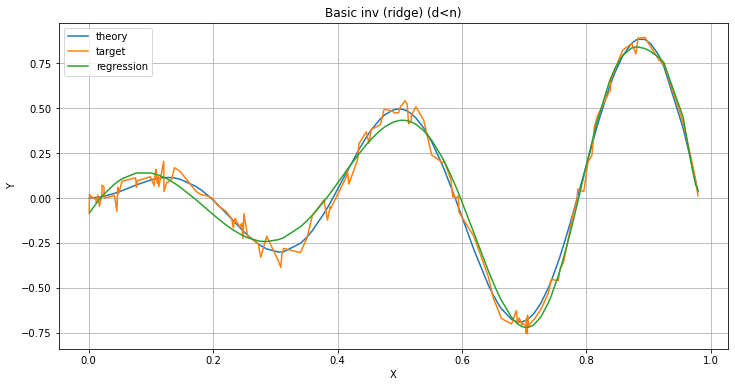

In [142]:
plt.figure(figsize=(12, 6))
plt.plot(x,function_f(x))
plt.plot(x,Y)
plt.plot(x,np.matmul(X,beta))

plt.xlabel("X")
plt.ylabel("Y")

plt.grid()

plt.legend(["theory", "target", "regression"])
plt.title("Basic inv (ridge) (d<n)")

In [143]:
X

array([[1.00000000e+000, 9.64589062e-004, 9.30432058e-007, ...,
        1.83691745e-142, 1.77187047e-145, 1.70912688e-148],
       [1.00000000e+000, 1.19071919e-003, 1.41781218e-006, ...,
        3.65628053e-138, 4.35360338e-141, 5.18391907e-144],
       [1.00000000e+000, 3.65407960e-003, 1.33522977e-005, ...,
        2.82205946e-115, 1.03120299e-117, 3.76809781e-120],
       ...,
       [1.00000000e+000, 9.70200222e-001, 9.41288471e-001, ...,
        2.41259472e-001, 2.34069993e-001, 2.27094759e-001],
       [1.00000000e+000, 9.75464415e-001, 9.51530825e-001, ...,
        3.11126682e-001, 3.03493007e-001, 2.96046629e-001],
       [1.00000000e+000, 9.79469012e-001, 9.59359545e-001, ...,
        3.77192386e-001, 3.69448254e-001, 3.61863116e-001]])

<b>Other experiments<b>

$d = n$ with polynomial functions. Method : Basic inversion used

In [144]:
# Parameters
n = 150
d = n
scale = 0.05

# creation of y and X
x = np.sort(np.random.uniform(size=n))
eps = np.random.normal(scale=scale,size=n)

Y = function_f(x)+eps
X = create_X(x,function_poly,d)

# regression
beta, XX_1, z_n = linear_regression(Y,X)

Basic inversion used, with lambda :  1e-07


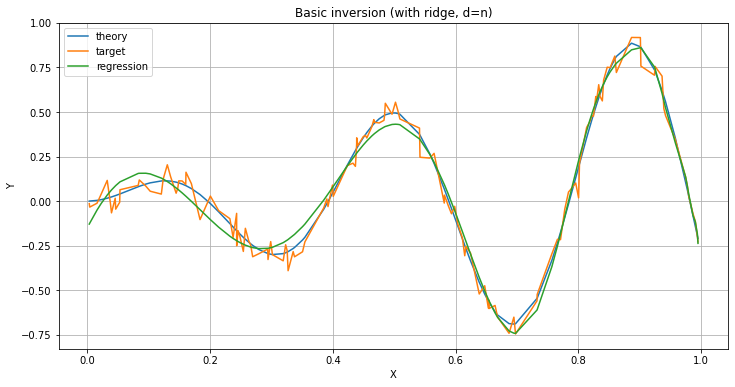

In [145]:
plt.figure(figsize=(12, 6))
plt.plot(x,function_f(x))
plt.plot(x,Y)
plt.plot(x,np.matmul(X,beta))

plt.xlabel("X")
plt.ylabel("Y")

plt.grid()

plt.title("Basic inversion (with ridge, d=n)")
plt.legend(["theory", "target", "regression"])

SVD method with $d>n$ and we use as a basis exponential functions. It is a least norm problem.

In [146]:
# Parameters
n = 100
d = 150
scale = 0.05

# creation of y and X
x = np.sort(np.random.uniform(size=n))
eps = np.random.normal(scale=scale,size=n)

Y = function_f(x)+eps
X = create_X(x,function_exp,d)

# regression
beta, XX_1, z_n = linear_regression(Y,X)

SVD used (with also QR decomposition)


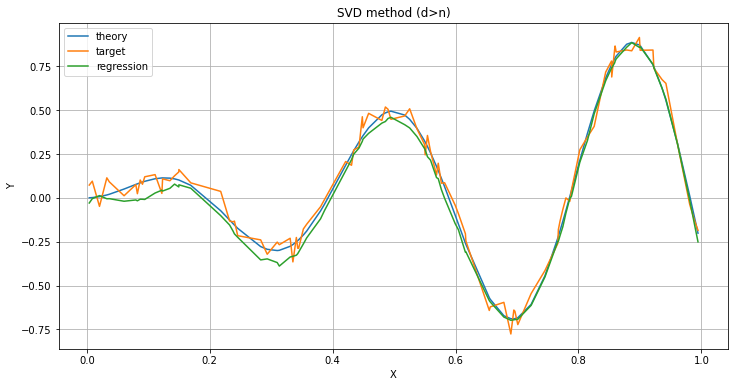

In [147]:
plt.figure(figsize=(12, 6))
plt.plot(x,function_f(x))
plt.plot(x,Y)
plt.plot(x,np.matmul(X,beta))

plt.xlabel("X")
plt.ylabel("Y")

plt.grid()

plt.title("SVD method (d>n)")
plt.legend(["theory", "target", "regression"])

<b>Implement recursivity to linear regression

In [148]:
# Parameters
n = 150 + 1 # we add one more sample
d = 150
scale = 0.05

# creation of y
x = np.sort(np.random.uniform(size=n))
eps = np.random.normal(scale=scale,size=n)

Y = function_f(x)+eps
X = create_X(x,function_poly,d)

# we dont use all the sample (we use the number of samples - 1)
beta, XX_1, z_n = linear_regression(Y[:n-1],X[:n-1])

Basic inversion used, with lambda :  1e-07


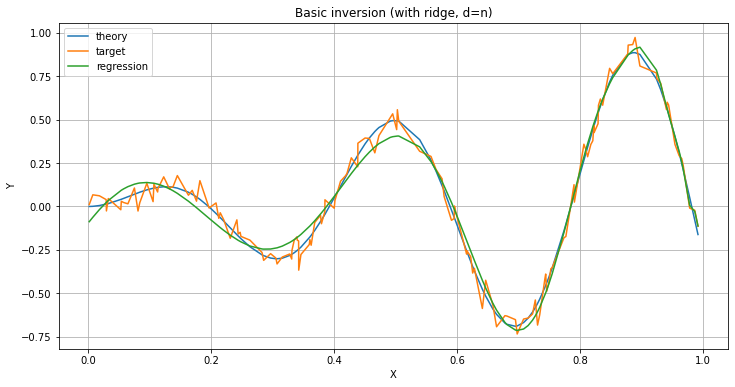

In [149]:
plt.figure(figsize=(12, 6))
plt.plot(x[:n-1],function_f(x)[:n-1])
plt.plot(x[:n-1],Y[:n-1])
plt.plot(x[:n-1],np.matmul(X[:n-1],beta))

plt.xlabel("X")
plt.ylabel("Y")

plt.grid()

plt.title("Basic inversion (with ridge, d=n)")
plt.legend(["theory", "target", "regression"])

This function calculate the inverse of $(XX + \psi_{n} . \psi_{n}^T)^{-1}$ with $XX^{-1}$ and  $\psi_{n}$ in a more efficient way.

In [150]:
def sherman_morrison(XX_1,X_n_1):
  num = np.matmul(XX_1,np.matmul(X_n_1,np.matmul(X_n_1.transpose(),XX_1)))
  denum = 1 + np.matmul(X_n_1.transpose(),np.matmul(XX_1,X_n_1))

  return XX_1 - num/denum

This function is the main function for recursivity, it is the formula from the course.

In [151]:
def recursive_linear_regression(Y_n_1, X_n_1, XX, z_n):
  first_term = sherman_morrison(XX_1,X_n_1)
  second_term = z_n.reshape(z_n.shape[0],1) + X_n_1*Y_n_1

  return np.matmul(first_term,second_term)

We create a new beta with the addition of a new sample. To do so, we use the previous function.

In [152]:
X_n_1 = X[n-1].reshape(X[n-1].shape[0],1)
Y_n_1 = Y[n-1]

new_beta = recursive_linear_regression(Y_n_1, X_n_1, XX_1, z_n)
print("Shape of beta :\n", new_beta.shape)
print("First five rows :\n", new_beta[:5])

Shape of beta :
 (150, 1)
First five rows :
 [[-9.76653885e-02]
 [ 4.52908252e+00]
 [-1.15254718e+01]
 [-1.62621561e+02]
 [ 6.40820772e+02]]


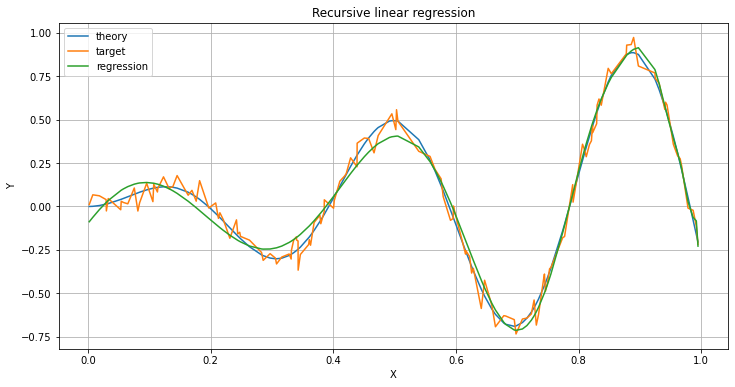

In [153]:
plt.figure(figsize=(12, 6))
plt.plot(x,function_f(x))
plt.plot(x,Y)
plt.plot(x,np.matmul(X,new_beta))

plt.xlabel("X")
plt.ylabel("Y")

plt.grid()

plt.title("Recursive linear regression")
plt.legend(["theory", "target", "regression"])

In [154]:
np.matmul(X.transpose(),X).shape

(150, 150)

Difference in L2 norm of beta

In [155]:
np.linalg.norm(beta-new_beta)

25117.9395342386

# Exercice 2

The goal of the exercice 2 is to plot the confidence ellipsoids of a linear regression of a time serie.

$\forall$ $t \in \{2,3,...\}$, $y_t = a · y_{t−1} + b · y_{t−2} + ε_t$ with $y_{0}=$y_0 and $y_{1}=$y_1

In [156]:
# Parameters of the time serie
# first value
y_0 = 1
y_1 = 2

# coefficients
a = 0.5
b = 0.3

# scale of error
scale = 1

# number of points
n = 100

Creation of trajectory and linear regression

In [157]:
def create_traj(y_0,y_1,a,b, n, scale = 0.01):

  y = np.zeros(n)
  x = np.zeros((n,2))

  # initial condition
  y[0] = y_0
  y[1] = y_1

  # creation of trajectory
  for t in range(2,n):
    y[t] = a*y[t-1] + b*y[t-2] + np.random.normal(scale=scale)

    x[t][0] = y[t-1]
    x[t][1] = y[t-2]

  return y, x

In [158]:
Y_2,X_2 = create_traj(y_0,y_1,a,b, n, scale)
beta_2,XX_1,z_n = linear_regression(Y_2[2:],X_2[2:])
print(beta_2)

SVD not used, QR decomposition > backward Substitution
[0.67984442 0.15627315]


The offset between the time serie and its prediction is certainly due to the errors that are great compared the serie without noise. It is a parameter that can be changed and the code will work because we calculate through a function the empirical deviation of the regression.

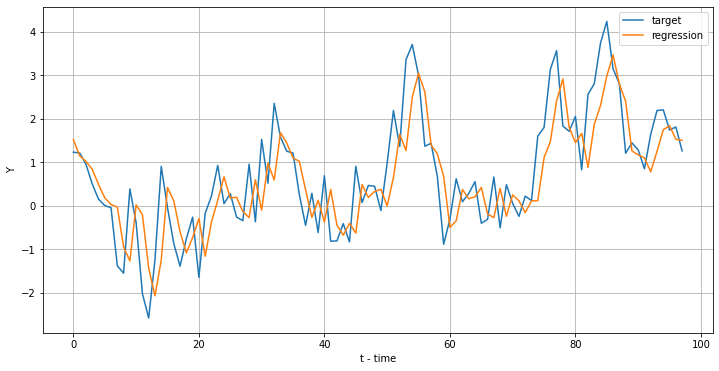

In [159]:
plt.figure(figsize=(12, 6))
plt.plot(Y_2[2:])
plt.plot(np.matmul(X_2[2:],beta_2))

plt.xlabel("t - time")
plt.ylabel("Y")

plt.grid()

plt.legend([ "target", "regression"])

Creation of confidence ellipsoids

This function will say given a test beta, the beta of the linear regression, X, $\sigma_n$  and q (the quantile) if the inequality of the course is verified. It will return True or False depending on the result.

In [160]:
def verify_ineq(beta_test,beta, X, sigma_n, q):

  first_term = (beta_test-beta).transpose()
  third_term = (beta_test-beta)
  XX = np.matmul(X.transpose(),X)

  res =  np.matmul(np.matmul(first_term,XX),third_term)

  return res <= sigma_n * q

This function calculates the empirical deviation of the linear regression. More n is large and more it will be precise.

In [161]:
def calc_sigma_n(Y,X,beta):
  pred = np.matmul(X,beta)
  quad_err = (Y-pred).dot(Y-pred)
  sigma_n = np.sqrt(1/(n-len(beta))*np.sum(quad_err))
  return sigma_n

This function is the main function. It will try a grid of test betas and will pass them through the fucntion to verify the inequality. If it returns True, we keep this beta in an array otherwise we forget it. 

In [162]:
def bruteforce(Y, beta, X, min_beta, max_beta, nb_beta_0, nb_beta_1, alpha):
  beta_conf = []

  # we use the good quantile
  d = len(beta)
  q = chi2.ppf(alpha, d)

  # we calculate the empirical sigma_n
  sigma_n = calc_sigma_n(Y, X, beta)

  # we test nb_beta_0 * nb_beta_1 betas
  for i in range(nb_beta_0):
    if i/nb_beta_0*100 % 5 == 0 :
      print(int(i/nb_beta_0*100), "%")

    for j in range(nb_beta_1):

      # we rescale it in the interval that we want
      beta_test = [i*(max_beta-min_beta)/nb_beta_0+min_beta, j*(max_beta-min_beta)/nb_beta_1+min_beta]
      beta_test = np.array(beta_test).reshape((2,))

      # we add the beta if it verifies the inequality
      if verify_ineq(beta_test, beta, X, sigma_n, q) :
        beta_conf.append(beta_test)

  return np.array(beta_conf)


In [163]:
# parameters for the interval of beta and their numbers
min_beta = -0.5
max_beta = 1

nb_beta_0 = 200
nb_beta_1 = 150

In [164]:
calc_sigma_n(Y_2,X_2,beta_2)

0.9104328171809153

We find the betas that construct the confidence ellipsoids for a confidence of 0.9, 0.95 and 0.99

In [165]:
res_bruteforce_09 = bruteforce(Y_2, beta_2, X_2, min_beta,max_beta,nb_beta_0, nb_beta_1, 0.9)
res_bruteforce_095 = bruteforce(Y_2, beta_2, X_2, min_beta,max_beta, nb_beta_0, nb_beta_1, 0.95)
res_bruteforce_099 = bruteforce(Y_2, beta_2, X_2, min_beta,max_beta, nb_beta_0, nb_beta_1, 0.99)

0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %


In [166]:
print(res_bruteforce_09.shape)
print(res_bruteforce_095.shape)
print(res_bruteforce_099.shape)

(1307, 2)
(1700, 2)
(2604, 2)


We then plot all these betas on a graph. Depending on the errors, the graph below will change place. We observe that the true beta is in the 0.9 confidence ellipsoid.

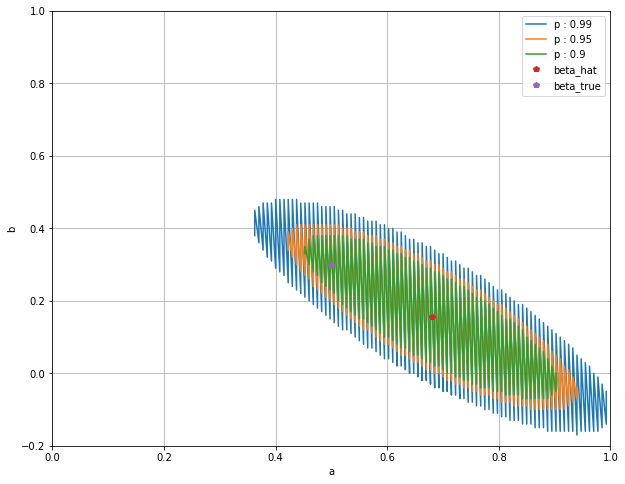

In [167]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlim(0, 1)
ax.set_ylim(-0.2, 1)

plt.plot(res_bruteforce_099[:,0],res_bruteforce_099[:,1],)
plt.plot(res_bruteforce_095[:,0],res_bruteforce_095[:,1],)
plt.plot(res_bruteforce_09[:,0],res_bruteforce_09[:,1],)


plt.plot(beta_2[0],beta_2[1], 'p')
plt.plot(a,b, 'p')

plt.xlabel("a")
plt.ylabel("b")

plt.grid()
plt.legend(["p : 0.99","p : 0.95","p : 0.9","beta_hat","beta_true"])